### This notebook aims to test simulated data with MAPIE

In [3]:
import numpy as np
import pandas as pd

import warnings

from matplotlib import pylab as plt
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

from mapie.metrics import (regression_coverage_score,
                           regression_mean_width_score)
from mapie.subsample import BlockBootstrap
from mapie.regression import MapieTimeSeriesRegressor

warnings.simplefilter("ignore")

### Generate Simulated Data (State Space Model):

$Y_t = \alpha Y_{t-1} + \epsilon_t$

$\epsilon_t = \beta \epsilon_{t-1} + v_t$

In [10]:
def get_simu_data_simple(num_pts, alpha, beta):
    '''
        Y_t = alpha*Y_{t-1}+\eps_t
        \eps_t = beta*\eps_{t-1}+v_t
        v_t ~ N(0,1)
        So X_t = Y_{t-1}, f(X_t) = alpha*X_t
        If t = 0:
            X_t = 0, Y_t=\eps_t = v_t
    '''
    np.random.seed(1)
    v0 = np.random.randn(1)
    Y, X, fX, eps = [v0], [np.zeros(1)], [np.zeros(1)], [v0]
    scale = np.sqrt(0.1)
    for _ in range(num_pts-1):
        vt = np.random.randn(1) * scale
        X.append(Y[-1])
        fX.append(alpha*Y[-1])
        eps.append(beta*eps[-1]+vt)
        Y.append(fX[-1]+eps[-1])

    data = np.column_stack((Y, X, fX, eps))
    df = pd.DataFrame(data, columns = ['Y', 'X', 'fX', 'eps'])
    return df, 'Y'

def one_dimen_transform(y_train, y_test, n_lags):
    n = len(y_train)
    n1 = len(y_test)
    X_train = np.zeros((n - n_lags, n_lags))  # from n_lags+1,...,n
    X_test = np.zeros((n1, n_lags))  # from n-n_lags,...,n+n1-n_lags
    for i in range(n - n_lags):
        X_train[i, :] = y_train[i : i + n_lags]
    for i in range(n1):
        if i < n_lags:
            X_test[i, :] = np.r_[y_train[n - n_lags + i :], y_test[:i]]
        else:
            X_test[i, :] = y_test[i - n_lags : i]
    y_train = y_train[n_lags:]
    return [X_train, X_test, y_train, y_test]

In [4]:
data_df, target_col = get_simu_data_simple(num_pts=2000, alpha=0.8, beta=0.9)

In [5]:
train_frac = 0.8
train_size = int(len(data_df) * train_frac)
train_df = data_df[:train_size].copy()
test_df = data_df[train_size:].copy()


### Plot the data

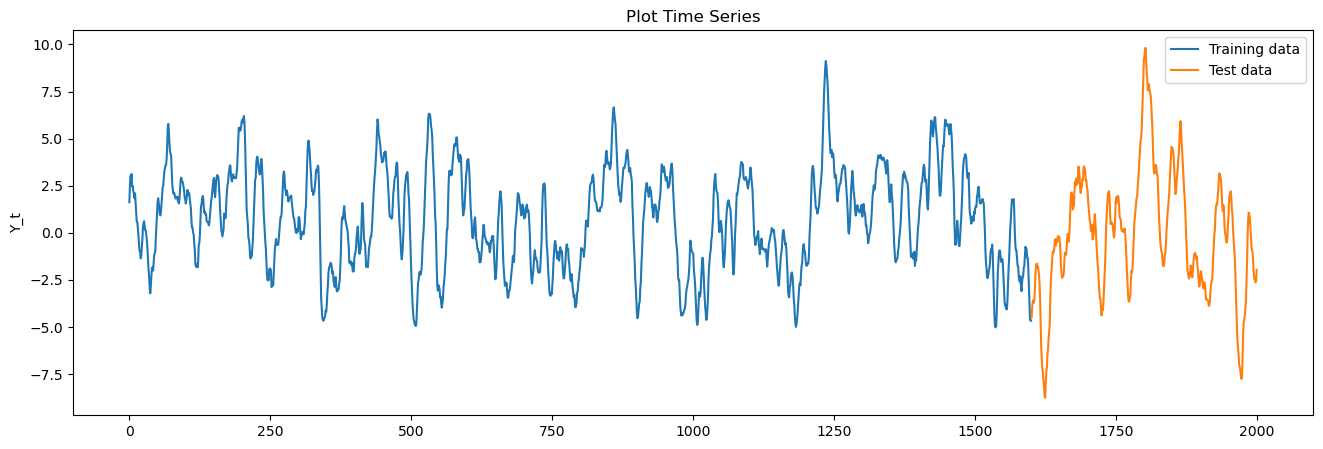

In [6]:
plt.figure(figsize=(16, 5))
plt.plot(train_df['Y'])
plt.plot(test_df['Y'])
plt.ylabel("Y_t")
plt.legend(["Training data", "Test data"])
plt.title('Plot Time Series')
plt.show()

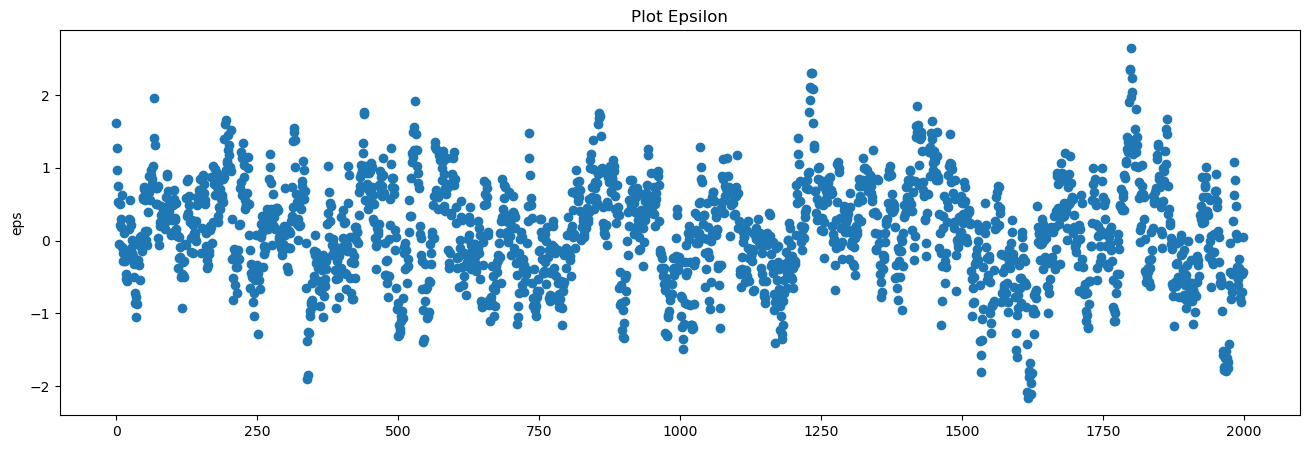

In [7]:
plt.figure(figsize=(16, 5))
# plt.plot(data_df['eps'])
plt.scatter(data_df.index, data_df['eps'])
plt.ylabel("eps")
plt.title('Plot Epsilon')
plt.show()

### Search for optimized parameters for base estimator 

In [8]:
y_train = train_df['Y']
X_train = train_df['X'].to_numpy().reshape(-1,1)
y_test = test_df['Y']
X_test = test_df['X'].to_numpy().reshape(-1,1)

In [9]:
train_df['X']

0       0.000000
1       1.624345
2       2.567933
3       3.028934
4       2.960975
          ...   
1595   -1.827742
1596   -2.729363
1597   -3.683590
1598   -4.550916
1599   -4.668551
Name: X, Length: 1600, dtype: float64

In [10]:
model_params_fit_not_done = True
if model_params_fit_not_done:
    # CV parameter search
    n_iter = 100
    n_splits = 5
    tscv = TimeSeriesSplit(n_splits=n_splits)
    random_state = 59
    rf_model = RandomForestRegressor(random_state=random_state)
    rf_params = {"max_depth": randint(2, 30), "n_estimators": randint(2, 100)}
    cv_obj = RandomizedSearchCV(
        rf_model,
        param_distributions=rf_params,
        n_iter=n_iter,
        cv=tscv,
        scoring="neg_root_mean_squared_error",
        random_state=random_state,
        verbose=0,
        n_jobs=-1,
    )
    cv_obj.fit(X_train, y_train)
    model = cv_obj.best_estimator_

else:
    # Model: Random Forest previously optimized with a cross-validation
    model = RandomForestRegressor(
        max_depth=10, n_estimators=50, random_state=59
    )

In [11]:
model

RandomForestRegressor(max_depth=5, n_estimators=4, random_state=59)

In [12]:
alpha = 0.1
gap = 1
cv_mapiets = BlockBootstrap(
    n_resamplings=10, n_blocks=10, overlapping=False, random_state=59
)
mapie_enbpi = MapieTimeSeriesRegressor(
    model, method="enbpi", cv=cv_mapiets, agg_function="mean", n_jobs=-1
)

In [13]:
BlockBootstrap(
    n_resamplings=10, n_blocks=10, overlapping=False, random_state=59
)

BlockBootstrap(length=None, n_blocks=10, n_resamplings=10, overlapping=False,
        random_state=59)

In [14]:
mapie_enbpi = mapie_enbpi.fit(X_train, y_train)
mapie_enbpi

MapieTimeSeriesRegressor(cv=BlockBootstrap(length=None, n_blocks=10, n_resamplings=10, overlapping=False,
        random_state=59),
                         estimator=RandomForestRegressor(max_depth=5,
                                                         n_estimators=4,
                                                         random_state=59),
                         n_jobs=-1)

### Regular Fit

In [16]:
y_pred_npfit, y_pis_npfit = mapie_enbpi.predict(X_test, alpha=alpha, ensemble=True, optimize_beta=True)
coverage_npfit = regression_coverage_score(
    y_test, y_pis_npfit[:, 0, 0], y_pis_npfit[:, 1, 0]
)
width_npfit = regression_mean_width_score(
    y_pis_npfit[:, 0, 0], y_pis_npfit[:, 1, 0]
)

In [17]:
coverage_npfit

0.8125

### Partial Fit

In [ ]:
y_pred_pfit = np.zeros(y_pred_npfit.shape)
y_pis_pfit = np.zeros(y_pis_npfit.shape)
conformity_scores_pfit = []
lower_quantiles_pfit = []
higher_quantiles_pfit = []
y_pred_pfit[:gap], y_pis_pfit[:gap, :, :] = mapie_enbpi.predict(
    X_test[:gap], alpha=alpha, ensemble=True, optimize_beta=True
)
for step in range(gap, len(X_test), gap):
    mapie_enbpi.partial_fit(
        X_test[(step - gap):step],
        y_test.iloc[(step - gap):step],
    )
    (
        y_pred_pfit[step:step + gap],
        y_pis_pfit[step:step + gap, :, :],
    ) = mapie_enbpi.predict(
        X_test[step:(step + gap)],
        alpha=alpha,
        ensemble=True,
        optimize_beta=True
    )
    conformity_scores_pfit.append(mapie_enbpi.conformity_scores_)
    lower_quantiles_pfit.append(mapie_enbpi.lower_quantiles_)
    higher_quantiles_pfit.append(mapie_enbpi.higher_quantiles_)
coverage_pfit = regression_coverage_score(
    y_test, y_pis_pfit[:, 0, 0], y_pis_pfit[:, 1, 0]
)
width_pfit = regression_mean_width_score(
    y_pis_pfit[:, 0, 0], y_pis_pfit[:, 1, 0]
)

In [ ]:
coverage_pfit

## Large Number of Trials

### Regular Fit

In [18]:
%%time
alpha = 0.1
gap = 1
trials=200
coverage_values_np=[]
width_values_np=[]
for itrial in range(trials):
    cv_mapiets = BlockBootstrap(
        n_resamplings=10, length=80, overlapping=False, random_state=itrial
    )
    mapie_enbpi = MapieTimeSeriesRegressor(
        model, method="enbpi", cv=cv_mapiets, agg_function="mean", n_jobs=-1
    )
    mapie_enbpi = mapie_enbpi.fit(X_train, y_train)

    #Regular Fit
    y_pred_npfit, y_pis_npfit = mapie_enbpi.predict(X_test, alpha=alpha, ensemble=True, optimize_beta=True)
    coverage_npfit = regression_coverage_score(
        y_test, y_pis_npfit[:, 0, 0], y_pis_npfit[:, 1, 0]
    )
    width_npfit = regression_mean_width_score(
        y_pis_npfit[:, 0, 0], y_pis_npfit[:, 1, 0]
    )
    coverage_values_np.append(coverage_npfit)
    width_values_np.append(width_npfit)

CPU times: user 32.4 s, sys: 6.94 s, total: 39.4 s
Wall time: 1min 36s


In [19]:
i = 1
# Initialize an empty list to store cumulative moving 
# averages 
moving_averages = [] 
  
# Store cumulative sums of array in cum_sum array 
cum_sum = np.cumsum(coverage_values_np); 
  
# Loop through the array elements 
while i <= len(coverage_values_np): 
  
    # Calculate the cumulative average by dividing 
    # cumulative sum by number of elements till  
    # that position 
    window_average = cum_sum[i-1] / i
      
    # Store the cumulative average of 
    # current window in moving average list 
    moving_averages.append(window_average) 
      
    # Shift window to right by one position 
    i += 1

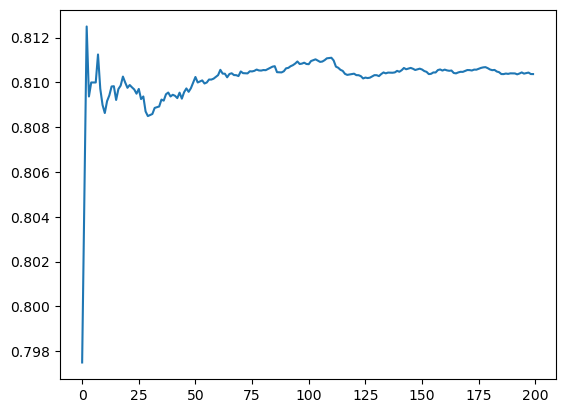

In [20]:
plt.plot(list(range(trials)), moving_averages)

# Testing on WN(0,1) data

In [1]:
#Simulate Gaussian white noises ~(0,1)
from random import gauss
from random import seed
from pandas import Series
from pandas.plotting import autocorrelation_plot
# seed random number generator
seed(1)
# create white noise series
series = [gauss(0.0, 1.0) for i in range(1000)]
series = Series(series)

In [2]:
def one_dimen_transform(y_train, y_test, n_lags):
    n = len(y_train)
    n1 = len(y_test)
    X_train = np.zeros((n - n_lags, n_lags))  # from n_lags+1,...,n
    X_test = np.zeros((n1, n_lags))  # from n-n_lags,...,n+n1-n_lags
    for i in range(n - n_lags):
        X_train[i, :] = y_train[i : i + n_lags]
    for i in range(n1):
        if i < n_lags:
            X_test[i, :] = np.r_[y_train[n - n_lags + i :], y_test[:i]]
        else:
            X_test[i, :] = y_test[i - n_lags : i]
    y_train = y_train[n_lags:]
    return [X_train, X_test, y_train, y_test]

In [3]:
train_frac = 0.8
train_size = int(len(series) * train_frac)
y_train = series[:train_size].copy()
y_test = series[train_size:].copy()

In [4]:
y_train

0      1.288185
1      1.449446
2      0.066336
3     -0.764544
4     -1.092173
         ...   
795   -1.161942
796    0.913235
797   -2.087676
798    1.587845
799   -0.843414
Length: 800, dtype: float64

In [10]:
n_lags=10
X_train, X_test, y_train, y_test=one_dimen_transform(y_train, y_test, n_lags)

In [14]:
from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression, LogisticRegressionCV
min_alpha = 0.0001
max_alpha = 10
model = LassoCV(alphas=np.linspace(min_alpha, max_alpha, 10))

In [17]:
%%time
alpha = 0.1
gap = 1
trials=2000
coverage_values_np=[]
width_values_np=[]
for itrial in range(trials):
    cv_mapiets = BlockBootstrap(
        n_resamplings=10, length=80, overlapping=False, random_state=itrial
    )
    mapie_enbpi = MapieTimeSeriesRegressor(
        model, method="enbpi", cv=cv_mapiets, agg_function="mean", n_jobs=-1
    )
    mapie_enbpi = mapie_enbpi.fit(X_train, y_train)

    #Regular Fit
    y_pred_npfit, y_pis_npfit = mapie_enbpi.predict(X_test, alpha=alpha, ensemble=True, optimize_beta=True)
    coverage_npfit = regression_coverage_score(
        y_test, y_pis_npfit[:, 0, 0], y_pis_npfit[:, 1, 0]
    )
    width_npfit = regression_mean_width_score(
        y_pis_npfit[:, 0, 0], y_pis_npfit[:, 1, 0]
    )
    coverage_values_np.append(coverage_npfit)
    width_values_np.append(width_npfit)

CPU times: user 2min 14s, sys: 21.3 s, total: 2min 36s
Wall time: 8min 51s


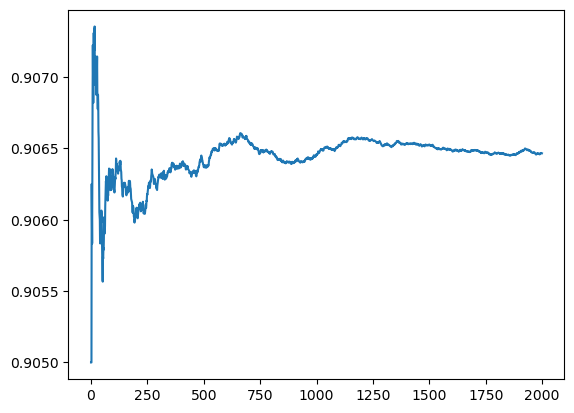

In [18]:
i = 1
# Initialize an empty list to store cumulative moving 
# averages 
moving_averages = [] 
  
# Store cumulative sums of array in cum_sum array 
cum_sum = np.cumsum(coverage_values_np); 
  
# Loop through the array elements 
while i <= len(coverage_values_np): 
  
    # Calculate the cumulative average by dividing 
    # cumulative sum by number of elements till  
    # that position 
    window_average = cum_sum[i-1] / i
      
    # Store the cumulative average of 
    # current window in moving average list 
    moving_averages.append(window_average) 
      
    # Shift window to right by one position 
    i += 1

plt.plot(list(range(trials)), moving_averages)

In [19]:
moving_averages[-1]

0.9064650000000001

In [5]:
n=len(y_train)

In [6]:
0.9+1/(n+1)

0.9012484394506867

In [12]:
%%time
alpha = 0.1
gap = 1
trials=2000
coverage_values_np=[]
width_values_np=[]
for itrial in range(trials):
    cv_mapiets = BlockBootstrap(
        n_resamplings=20, length=80, overlapping=True, random_state=itrial
    )
    mapie_enbpi = MapieTimeSeriesRegressor(
        model, method="enbpi", cv=cv_mapiets, agg_function="mean", n_jobs=-1
    )
    mapie_enbpi = mapie_enbpi.fit(X_train, y_train)

    #Regular Fit
    y_pred_npfit, y_pis_npfit = mapie_enbpi.predict(X_test, alpha=alpha, ensemble=True, optimize_beta=True)
    coverage_npfit = regression_coverage_score(
        y_test, y_pis_npfit[:, 0, 0], y_pis_npfit[:, 1, 0]
    )
    width_npfit = regression_mean_width_score(
        y_pis_npfit[:, 0, 0], y_pis_npfit[:, 1, 0]
    )
    coverage_values_np.append(coverage_npfit)
    width_values_np.append(width_npfit)

CPU times: user 2min 58s, sys: 23.7 s, total: 3min 21s
Wall time: 13min 7s


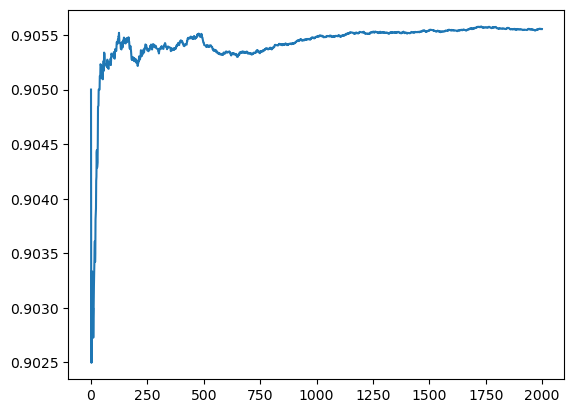

In [13]:
i = 1
# Initialize an empty list to store cumulative moving 
# averages 
moving_averages = [] 
  
# Store cumulative sums of array in cum_sum array 
cum_sum = np.cumsum(coverage_values_np); 
  
# Loop through the array elements 
while i <= len(coverage_values_np): 
  
    # Calculate the cumulative average by dividing 
    # cumulative sum by number of elements till  
    # that position 
    window_average = cum_sum[i-1] / i
      
    # Store the cumulative average of 
    # current window in moving average list 
    moving_averages.append(window_average) 
      
    # Shift window to right by one position 
    i += 1

plt.plot(list(range(trials)), moving_averages)

# Testing with Solar Atl data

In [4]:
def read_data(data_name, max_data_size):
    data_dir = "./Data"

    if data_name == "Solar_Atl":
        """
        4 (Alternative). NREL Solar data at Atlanta Downtown in 2018.
            - 24 observations per day and separately equally by 1H @ half an hour mark everytime
        Data descriptions see Solar Writeup
        Data download:
        (With API) https://nsrdb.nrel.gov/data-sets/api-instructions.html
        (Manual) https://maps.nrel.gov/nsrdb-viewer
        Properties:
            - Type: multivariate (5 temporal columns, 7 feature columns, 1 target)
            - Length: 8760
            - Period: entire 2018
            - Frequency: hourly (at every 30-min mark)
        """
        file_name = f"{data_name}_data.csv"
        data_df = pd.read_csv(file_name, skiprows=2)
        # data_df.shape  # 8760, 14
        data_df.drop(columns=data_df.columns[0:5], inplace=True)  # remove 5 temporal columns
        data_df.drop(columns="Unnamed: 13", inplace=True)
        # data_df.shape  # 8760, 8
        target_column = "DHI"

    elif data_name in _get_cali_cities():  # "Palo_Alto"
        """
        Properties:
            - Type: multivariate (1 datetime index, 5 temporal columns, 7 feature columns, 1 target)
            - Length: 8760
            - Period: entire 2018
            - Frequency: hourly
        """
        file_name = f"{data_name}_data.csv"
        data_df = pd.read_csv(file_name)
        data_df.drop(columns=data_df.columns[0:6], inplace=True)  # remove datetime index and 5 temporal columns
        target_column = "DHI"

    elif data_name == "appliances":
        """
        2. Appliances energy prediction Data Set
        The data set is at 10 min for about 4.5 months.
        The column named 'Appliances' is the response. Other columns are predictors
        https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction
        Properties:
            - Type: multivariate (1 temporal column, 27 feature columns, 1 target)
            - Length: 19735
            - Period: 2016-01-11 @5PM to 2016-05-27 @6PM
            - Frequency: every 10-min
        """
        file_name = f"{data_name}_data.csv"
        data_df = pd.read_csv(file_name, delimiter=",")
        # data_df.shape  # (19736, 29)
        data_df.drop("date", inplace=True, axis=1)  # remove the temporal column
        data_df.loc[:, data_df.columns != "Appliances"]
        target_column = "Appliances"

    elif data_name == "green_house":
        """
        All datasets are Multivariate time-series. They have respective Github for more details as well.
        1. Greenhouse Gas Observing Network Data Set
        Time from 5.10-7.31, 2010, with 4 samples everyday, 6 hours apart between data poits.
        Goal is to "use inverse methods to determine the optimal values of the weights in the weighted sum of 15 tracers that best matches the synthetic observations"
        In other words, find weights so that first 15 tracers will be as close to the last as possible.
        Note, data at many other grid cells are available. Others are in Downloads/🌟AISTATS Data/Greenhouse Data
        https://archive.ics.uci.edu/ml/datasets/Greenhouse+Gas+Observing+Network
        Properties:
            - Type: multivariate (15 feature columns aka tracers(?), 1 target)
            - Length: 327
            - Period: 2010-05-10 to 2010-07-31
            - Frequency: every 6-hours
        """
        file_name = f"{data_name}_data.csv"
        data_df = pd.read_csv(file_name, header=None, sep=" ").T
        # data_df.shape  # 327, 16 Note, rows are 16 time series (first 15 from tracers, last from synthetic).
        target_column = 15

    elif data_name == "Beijing_air":
        """
        3. Beijing Multi-Site Air-Quality Data Data Set
        This data set includes hourly air pollutants data from 12 nationally-controlled air-quality monitoring sites.
        Time period from 3.1, 2013 to 2.28, 2017.
        PM2.5 or PM10 would be the response.
        https://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data
        Properties:
            - Type: multivariate (1 index, 4 temporal columns, 12 feature columns, 1 target)
            - Length: 35064
            - Period: 2013-03-01 to 2017-02-28
            - Frequency: hourly
        """
        file_name = f"{data_name}_Tiantan_data.csv"
        data_df = pd.read_csv(file_name)
        # data_df.shape  # 35064, 18
        data_df.drop(
            columns=["No", "year", "month", "day", "hour", "wd", "station"],
            inplace=True,
            axis=1,
        )
        data_df.dropna(inplace=True)
        # data_df.shape  # 32907, 11
        target_column = "PM2.5"

    else:
        raise ValueError("data_name not found")   


    # pick maximum of X data points (for speed)
    data_df = data_df.iloc[: min(max_data_size, data_df.shape[0]), :]
    # shift target column back by one (for single-step forecast)
    data_df[target_column] = data_df[target_column].shift(-1)
    # remove final row as it does not contain target column value anymore
    data_df = data_df.iloc[:-1 , :]        

    return data_df, target_column


def _get_cali_cities():
    cali_cities = [
        "Fremont",
        "Milpitas",
        "Mountain_View",
        "North_San_Jose",
        "Palo_Alto",
        "Redwood_City",
        "San_Mateo",
        "Santa_Clara",
        "Sunnyvale",
    ]
    return cali_cities

In [11]:
DHI=read_data('Solar_Atl', max_data_size=10000)[0]['DHI']

In [12]:
train_frac = 0.8
train_size = int(len(DHI) * train_frac)

y_train = DHI[:train_size].copy()
y_test = DHI[train_size:].copy()
n_lags=10
X_train, X_test, y_train, y_test=one_dimen_transform(y_train, y_test, n_lags)

In [15]:
%%time
alpha = 0.1
gap = 1
trials=2000
coverage_values_np=[]
width_values_np=[]
for itrial in range(trials):
    cv_mapiets = BlockBootstrap(
        n_resamplings=20, length=80, overlapping=True, random_state=itrial
    )
    mapie_enbpi = MapieTimeSeriesRegressor(
        model, method="enbpi", cv=cv_mapiets, agg_function="mean", n_jobs=-1
    )
    mapie_enbpi = mapie_enbpi.fit(X_train, y_train)

    #Regular Fit
    y_pred_npfit, y_pis_npfit = mapie_enbpi.predict(X_test, alpha=alpha, ensemble=True, optimize_beta=True)
    coverage_npfit = regression_coverage_score(
        y_test, y_pis_npfit[:, 0, 0], y_pis_npfit[:, 1, 0]
    )
    width_npfit = regression_mean_width_score(
        y_pis_npfit[:, 0, 0], y_pis_npfit[:, 1, 0]
    )
    coverage_values_np.append(coverage_npfit)
    width_values_np.append(width_npfit)

CPU times: user 38min 53s, sys: 19min 48s, total: 58min 42s
Wall time: 1h 35min 19s


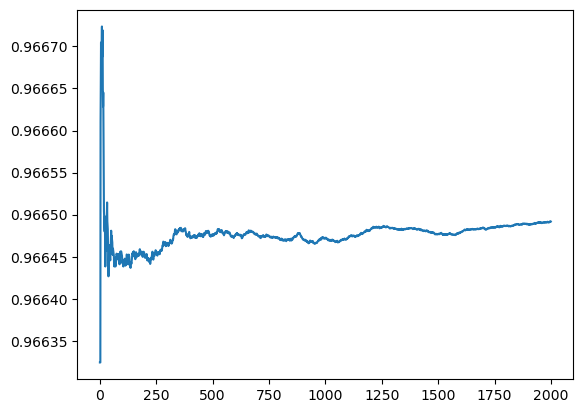

In [16]:
i = 1
# Initialize an empty list to store cumulative moving 
# averages 
moving_averages = [] 
  
# Store cumulative sums of array in cum_sum array 
cum_sum = np.cumsum(coverage_values_np); 
  
# Loop through the array elements 
while i <= len(coverage_values_np): 
  
    # Calculate the cumulative average by dividing 
    # cumulative sum by number of elements till  
    # that position 
    window_average = cum_sum[i-1] / i
      
    # Store the cumulative average of 
    # current window in moving average list 
    moving_averages.append(window_average) 
      
    # Shift window to right by one position 
    i += 1

plt.plot(list(range(trials)), moving_averages)